### SWT-MRA(1D)를 input으로 넣고 1D를 output으로 출력하는 모델 -> MRA level을 feature로 봄
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [1]:
# Ray Tune library

from functools import partial
import os
import tempfile
from pathlib import Path

import ray
ray.shutdown()
ray.init(local_mode=True)

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

2024-09-11 15:53:28,449	INFO worker.py:1783 -- Started a local Ray instance.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot, Result_Plot_paper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


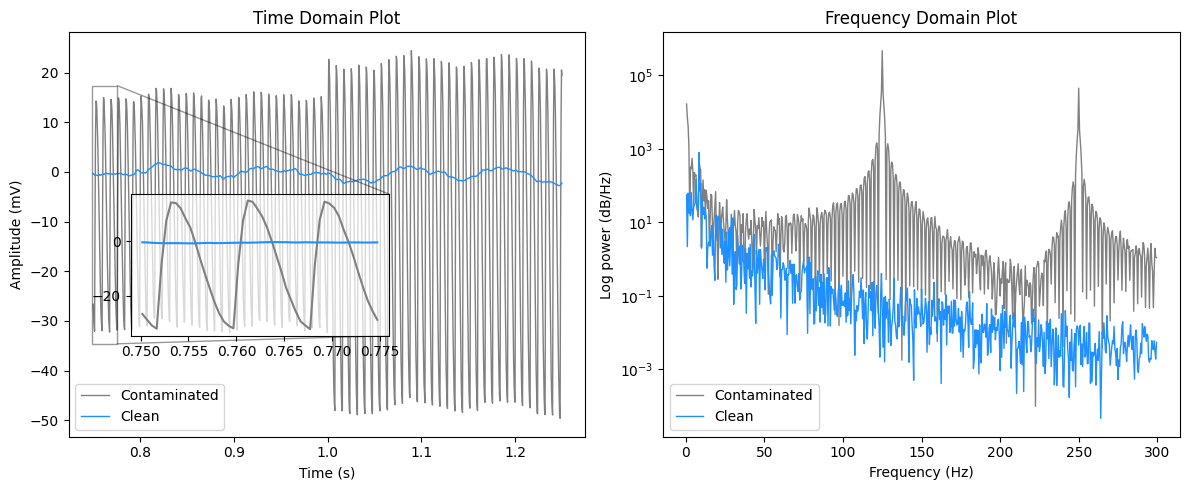

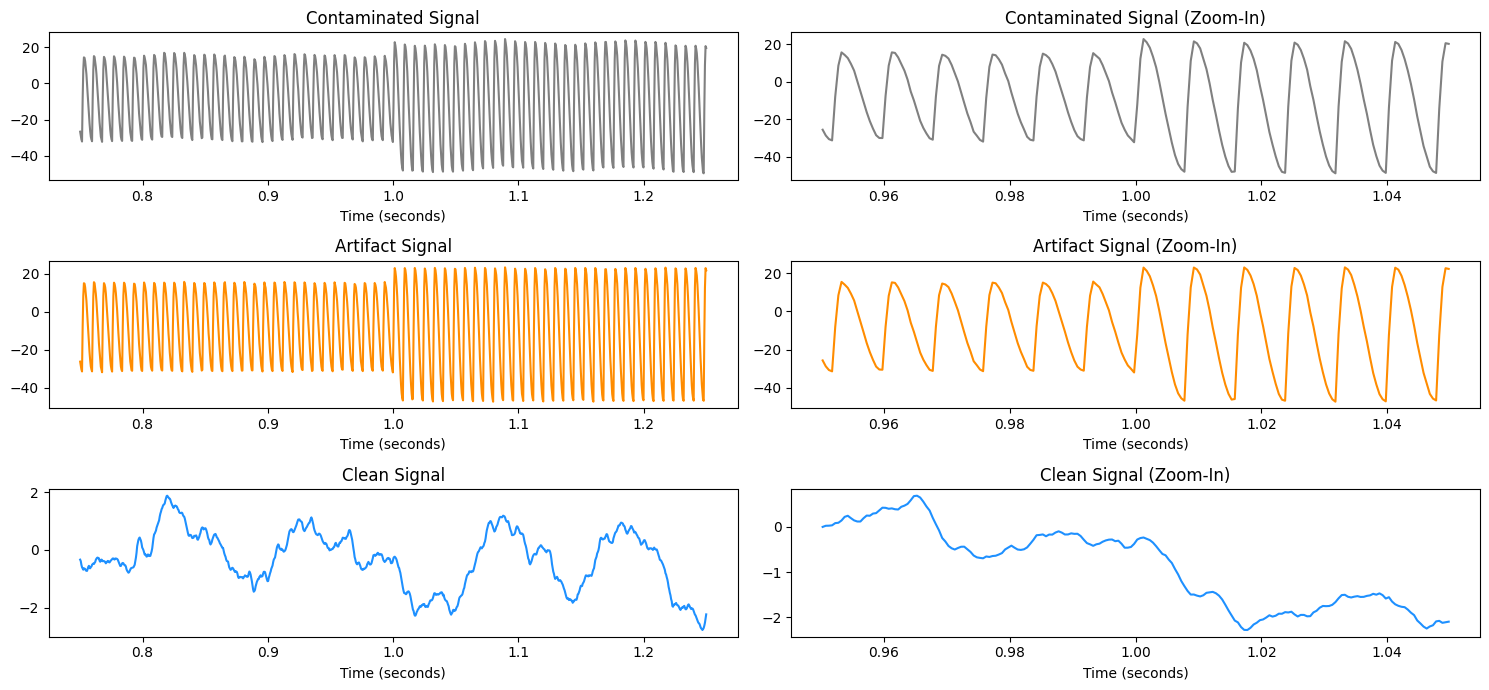

In [3]:
# 데이터 load & plot
datapath=  "C:/Users/stell/OneDrive/바탕 화면/10000_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

Contaminated_data = Contaminated_data[0:100]
Clean_data = Clean_data[0:100]
Artifact_data = Artifact_data[0:100]

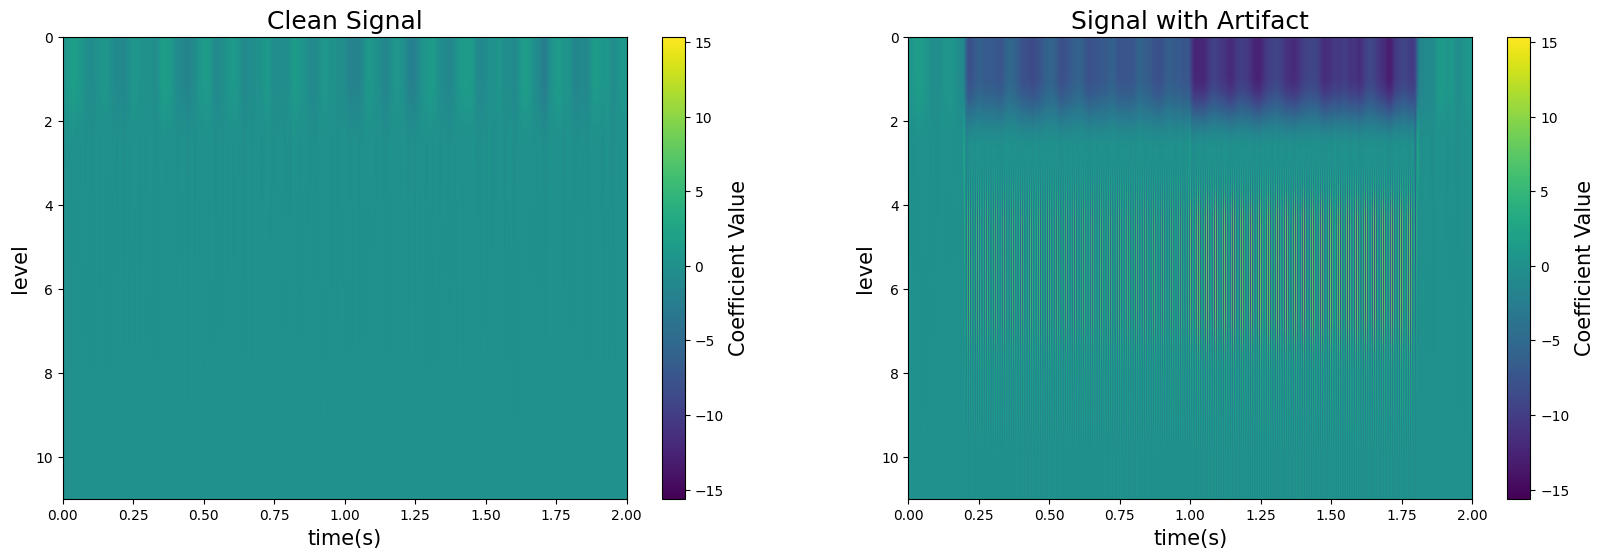

In [4]:
# SWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='swt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='swt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [5]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data, Clean_data):
    mra_x = pywt.mra(x, wavelet, transform='swt')
    mra_y = pywt.mra(y, wavelet, transform='swt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (100, 6, 4000)
y_wt: (100, 6, 4000)


In [6]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (100, 6, 4000)
y: (100, 6, 4000)


In [7]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Data Shape>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Data Shape>
-----------------------------
X_train shape: (80, 6, 4000)
y_train shape: (80, 6, 4000)
-----------------------------
X_test shape: (20, 6, 4000)
y_test shape: (20, 6, 4000)
-----------------------------


In [8]:
# # Test data 저장

# # MRA 결과 inverse scaling
# X_test_MRAinv = []
# y_test_MRAinv = []

# for xx, yy in zip(X_test, y_test):
#     flat_x = xx.flatten().reshape(-1, 1)
#     flat_y = yy.flatten().reshape(-1, 1)

#     inv_flat_x = scaler_x.inverse_transform(flat_x)
#     inv_flat_y = scaler_y.inverse_transform(flat_y)

#     X_test_MRAinv.append(inv_flat_x.reshape(xx.shape))
#     y_test_MRAinv.append(inv_flat_y.reshape(yy.shape))

# X_test_MRAinv = np.array(X_test_MRAinv)
# y_test_MRAinv = np.array(y_test_MRAinv)


# # MRA 데이터를 inverse하여 시계열 데이터로 변환
# X_test_time = []
# y_test_time = []

# for mra_x, mra_y in zip(X_test_MRAinv, y_test_MRAinv):
#     time_X = pywt.imra(mra_x)
#     time_y = pywt.imra(mra_y)
    
#     X_test_time.append(time_X)
#     y_test_time.append(time_y)

# X_test_time = np.array(X_test_time)
# y_test_time = np.array(y_test_time)

# print("X_reconstructed:", X_test_time.shape)
# print("y_reconstructed:", y_test_time.shape)

# np.save("../../../evaluation/Test_data/contaminated_by_realistic.npy", X_test_time)
# np.save("../../../evaluation/Test_data/clean_data.npy", y_test_time)

In [9]:
class CNN_MRA_1D(nn.Module):
    def __init__(self, l1=512, in_channels=6, out_channels=6):
        super(CNN_MRA_1D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv1d(in_channels, l1/8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(l1/8, l1/4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(l1/4, l1/2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(l1/2, l1, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        # Decoding path
        self.upconv4 = nn.ConvTranspose1d(l1, l1/2, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose1d(l1/2, l1/4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose1d(l1/4, l1/8, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv1d(l1/8, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        x4 = self.pool(self.gelu(self.conv4(x3)))

        # Decoding
        x4_up = self.upconv4(x4)
        x3_up = self.upconv3(x4_up)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

## Ray Tune 학습 함수

In [10]:
def train_ray(config, data_dir=None):
    model = CNN_MRA_1D(config["l1"], in_channels=6, out_channels=6).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])    

    # Check Point 저장
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = train_dataset, test_dataset

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs]
    )

    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )

    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
    )

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0): # 0 -> index가 0부터 시작
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_steps += 1

        # Ray Tune으로 통신하기
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [11]:
def test_accuracy(model, device="cpu"):
    trainset, testset = train_dataset, test_dataset

    criterion = nn.MSELoss()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=32, shuffle=False, num_workers=2
    )

    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss

## 검색 공간 구성

In [12]:
def main(num_samples=32, max_num_epochs=10, gpus_per_trial=1):

    data_dir = os.path.abspath("./data")
    # load_data(data_dir)
    config = {
        "l1": tune.choice([2**i for i in range(7, 12)]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16]),
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    result = tune.run(
        partial(train_ray, data_dir=data_dir),
        resources_per_trial={"gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        # storage_path="../raytune_model/ray_results"
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = CNN_MRA_1D(best_trial.config["l1"])
    # device = "cpu"
    # if torch.cuda.is_available():
    #     device = "cuda:0"
    #     if gpus_per_trial > 1:
    #         best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])
        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # 매 실험당 사용할 GPU 수를 여기에서 변경할 수 있습니다:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

2024-09-11 15:53:39,683	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
:job_id:01000000
:

:job_id:01000000
:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:40,495	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00001
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:40,733	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00002
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:40,988	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00003
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:41,253	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00004
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:41,507	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00005
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:41,801	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00006
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:42,058	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00007
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:42,328	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00008
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
2024-09-11 15:53:42,558	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray_937ab_00009
Traceback (most recent call last):
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\stell\anaconda3\envs\torch\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                     

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:func
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


TuneError: ('Trials did not complete', [train_ray_937ab_00000, train_ray_937ab_00001, train_ray_937ab_00002, train_ray_937ab_00003, train_ray_937ab_00004, train_ray_937ab_00005, train_ray_937ab_00006, train_ray_937ab_00007, train_ray_937ab_00008, train_ray_937ab_00009])

In [ ]:
# # 모델 파라미터 저장
# torch.save(model.state_dict(), '../../../saved_data/saved_model/CNN_IO_MRA_1D_swt_10000.pth')
# torch.save(model.state_dict(), '../../../evaluation/CNN_IO_MRA_1D_swt_10000.pth')

In [ ]:
# # 모델 평가
# Contaminated = torch.tensor([])
# Clean = torch.tensor([])
# SACed = torch.tensor([])

# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for x, y in test_loader:
#         x, y = x.to(device), y.to(device)
        
#         y_pred = model(x)
#         loss = criterion(y_pred, y)
#         test_loss += loss.item() * x.size(0)

#         Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
#         SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
#         Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss:.4f}')

In [ ]:
# # MRA Plot
# SACed_ex = SACed[0].detach().cpu()
# Clean_ex = Clean[0].detach().cpu()

# vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

# plt.figure(figsize=(20, 8))
# plt.subplot(1, 2, 1)
# plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
# plt.colorbar().set_label('Coefficient Value', fontsize=15)
# plt.xlabel('time(s)', fontsize=15)
# plt.ylabel('level', fontsize=15)
# plt.title('SACed signal', fontsize=20)

# plt.subplot(1, 2, 2)
# plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
# plt.colorbar().set_label('Coefficient Value', fontsize=15)
# plt.xlabel('time(s)', fontsize=15)
# plt.ylabel('level', fontsize=15)
# plt.title('Clean signal', fontsize=20)

# plt.tight_layout()

# print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
# print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

In [ ]:
# # MRA 결과 inverse scaling
# Contaminated_inverse_scaled = []
# SACed_inverse_scaled = []
# Clean_inverse_scaled = []

# for xx, yhat, yy in zip(Contaminated, SACed, Clean):
#     flat_x = xx.flatten().reshape(-1, 1)
#     flat_yhat = yhat.flatten().reshape(-1, 1)
#     flat_y = yy.flatten().reshape(-1, 1)

#     inv_flat_x = scaler_x.inverse_transform(flat_x)
#     inv_flat_yhat = scaler_y.inverse_transform(flat_yhat)
#     inv_flat_y = scaler_y.inverse_transform(flat_y)

#     Contaminated_inverse_scaled.append(inv_flat_x.reshape(xx.shape))
#     SACed_inverse_scaled.append(inv_flat_yhat.reshape(yhat.shape))
#     Clean_inverse_scaled.append(inv_flat_y.reshape(yy.shape))

# Contaminated_inverse_scaled = np.array(Contaminated_inverse_scaled)
# SACed_inverse_scaled = np.array(SACed_inverse_scaled)
# Clean_inverse_scaled = np.array(Clean_inverse_scaled)


# # MRA 데이터를 inverse하여 시계열 데이터로 변환

# Contaminated_invdwt = []
# SACed_invdwt = []
# Clean_invdwt = []

# for mra_x, mra_yhat, mra_y in zip(Contaminated_inverse_scaled, SACed_inverse_scaled, Clean_inverse_scaled):
#     contaminated_invdwt = pywt.imra(mra_x)
#     saced_invdwt = pywt.imra(mra_yhat)
#     clean_invdwt = pywt.imra(mra_y)
    
#     Contaminated_invdwt.append(contaminated_invdwt)
#     SACed_invdwt.append(saced_invdwt)
#     Clean_invdwt.append(clean_invdwt)

# Contaminated_invdwt = np.array(Contaminated_invdwt)
# SACed_invdwt = np.array(SACed_invdwt)
# Clean_invdwt = np.array(Clean_invdwt)

# print("X_reconstructed:", Contaminated_invdwt.shape)
# print("yhat_reconstructed:", SACed_invdwt.shape)
# print("y_reconstructed:", Clean_invdwt.shape)

In [ ]:
# # 결과 Plot

# save_path = '../../../result/data_10000/CNN/'
# save_title = 'CNN_IO_MRA_1D_swt'

# Result_Plot(Contaminated_invdwt, SACed_invdwt, Clean_invdwt, save_path, save_title) # inverse scaled data를 input으로 넣음

In [ ]:
# # Paper 결과 저장
# save_path = '../../../result/evaluation/'
# save_title = 'CNN_IO_MRA_1D_swt_10000'
# Result_Plot_paper(Contaminated_invdwt, SACed_invdwt, Clean_invdwt, save_path, save_title) # inverse scaled data를 input으로 넣음